In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report)

In [2]:
train_df = pd.read_pickle("train.pkl")
test_df = pd.read_pickle("test.pkl")

In [3]:
X_train = train_df.drop("label", axis=1)
y_train = train_df["label"]

X_test = test_df.drop("label", axis=1)
y_test = test_df["label"]

In [4]:
# Pipeline com SMOTE e Random Forest
pipeline_rf = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Espaço de busca dos hiperparâmetros conforme exemplo do PDF:
# - n_estimators: valores inteiros de 50 a 300
# - max_depth: valores inteiros de 3 a 20
param_dist_rf = {
    'rf__n_estimators': range(50, 301, 50),            # Valores: 50, 100, 150, 200, 250, 300
    'rf__max_depth': [None] + list(range(5, 26, 5)),      # None, 5, 10, 15, 20, 25
    'rf__min_samples_split': range(2, 11),              # 2 até 10
    'rf__min_samples_leaf': range(1, 5),                # 1 até 4
    'rf__bootstrap': [True, False]                      # Uso de bootstrap: True ou False
}

# Configurando a validação cruzada estratificada (k=5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [5]:
# Célula 3: Rodando n_runs vezes e armazenando resultados

n_runs = 20

best_scores_rf = []          # F1 de teste em cada rodada (ou outra métrica)
best_params_rf = []          # Hiperparâmetros encontrados em cada rodada
cv_results_history = []       # Para armazenar o cv_results_ de cada rodada (médias e desvios)

for i in range(n_runs):
    print(f"\nRodada {i+1}/{n_runs}")
    
    # Ajustamos o RandomizedSearchCV
    rf_search = RandomizedSearchCV(
        estimator=pipeline_rf,
        param_distributions=param_dist_rf,
        n_iter=5,                # 5 iterações
        scoring='f1_macro',       # Métrica de interesse principal
        cv=cv,
        random_state=42 + i,      # Muda para cada rodada
        n_jobs=-1,
        verbose=1
    )
    
    rf_search.fit(X_train, y_train)
    
    # Armazena histórico completo de desempenho dessa rodada
    cv_results = pd.DataFrame(rf_search.cv_results_)
    cv_results_history.append(cv_results)
    
    # Pega o melhor modelo e avalia no conjunto de teste
    best_model_rf = rf_search.best_estimator_
    y_pred_test = best_model_rf.predict(X_test)
    
    # Métrica de teste (F1 macro, por exemplo)
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    
    best_scores_rf.append(f1_test)
    best_params_rf.append(rf_search.best_params_)
    
    print("Melhores hiperparâmetros (validação cruzada):", rf_search.best_params_)
    print("Melhor F1 (validação cruzada - média):", rf_search.best_score_)
    print("F1 no Teste:", f1_test)



Rodada 1/20
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores hiperparâmetros (validação cruzada): {'rf__n_estimators': 200, 'rf__min_samples_split': 4, 'rf__min_samples_leaf': 1, 'rf__max_depth': 25, 'rf__bootstrap': True}
Melhor F1 (validação cruzada - média): 0.9606634450041692
F1 no Teste: 0.9576371185619852

Rodada 2/20
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores hiperparâmetros (validação cruzada): {'rf__n_estimators': 300, 'rf__min_samples_split': 7, 'rf__min_samples_leaf': 3, 'rf__max_depth': 20, 'rf__bootstrap': False}
Melhor F1 (validação cruzada - média): 0.9603578740503471
F1 no Teste: 0.959390134020063

Rodada 3/20
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores hiperparâmetros (validação cruzada): {'rf__n_estimators': 50, 'rf__min_samples_split': 7, 'rf__min_samples_leaf': 2, 'rf__max_depth': None, 'rf__bootstrap': True}
Melhor F1 (validação cruzada - média): 0.9589525325168735
F1 no Teste: 0.95728409455000

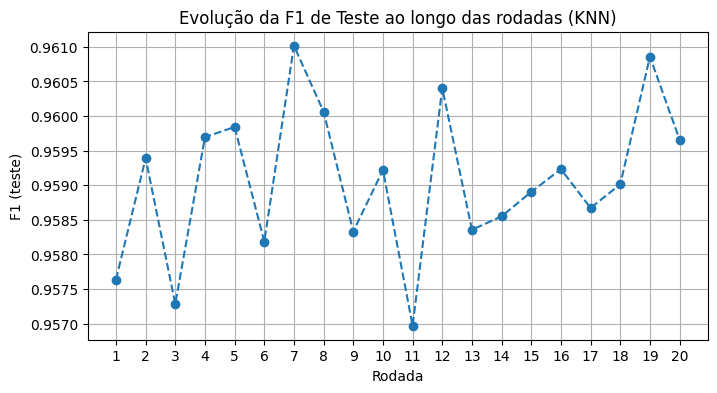

In [6]:
# Célula 4: Plotar evolução dos resultados de cada rodada (opcional)

plt.figure(figsize=(8, 4))
plt.plot(range(1, n_runs+1), best_scores_rf, marker='o', linestyle='--')
plt.title('Evolução da F1 de Teste ao longo das rodadas (KNN)')
plt.xlabel('Rodada')
plt.ylabel('F1 (teste)')
plt.xticks(range(1, n_runs+1))
plt.grid(True)
plt.show()


In [7]:
# Célula 5: Selecionar a melhor rodada entre as n_runs

best_run_index = np.argmax(best_scores_rf)
print(f"Melhor rodada: {best_run_index+1}")
print(f"F1 nessa rodada: {best_scores_rf[best_run_index]}")
print("Melhores hiperparâmetros:", best_params_rf[best_run_index])


Melhor rodada: 7
F1 nessa rodada: 0.9610156747599901
Melhores hiperparâmetros: {'rf__n_estimators': 100, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_depth': 25, 'rf__bootstrap': False}


In [9]:
# Célula 6: Treinamento final do melhor modelo com TODO o conjunto de treino

melhores_parametros = best_params_rf[best_run_index]

best_rf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=melhores_parametros['rf__n_estimators'],
        max_depth=melhores_parametros['rf__max_depth'],
        min_samples_split=melhores_parametros['rf__min_samples_split'],
        min_samples_leaf=melhores_parametros['rf__min_samples_leaf'],
        bootstrap=melhores_parametros['rf__bootstrap'],
        random_state=42
    ))
])

best_rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=25,
                                        min_samples_split=5,
                                        random_state=42))])

In [10]:
# Célula 7: Avaliação final no conjunto de teste

y_pred = best_rf_pipeline.predict(X_test)
y_proba = best_rf_pipeline.predict_proba(X_test)[:, 1]  # Para AUC (se for binário)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Se for binário, é possível calcular ROC
try:
    auc = roc_auc_score(y_test, y_proba)
except ValueError:
    auc = None  # Caso seja problema multiclasse ou algo que impeça o cálculo de AUC

print("\nDesempenho no Conjunto de Teste:")
print(f"Acurácia  : {acc:.4f}")
print(f"Precisão  : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")
if auc is not None:
    print(f"AUC       : {auc:.4f}")

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))



Desempenho no Conjunto de Teste:
Acurácia  : 0.9681
Precisão  : 0.9596
Recall    : 0.9624
F1-score  : 0.9610
AUC       : 0.9943

Matriz de Confusão:
[[1869  100]
 [ 120 4804]]

Relatório de Classificação:
              precision    recall  f1-score   support

        -1.0       0.94      0.95      0.94      1969
         1.0       0.98      0.98      0.98      4924

    accuracy                           0.97      6893
   macro avg       0.96      0.96      0.96      6893
weighted avg       0.97      0.97      0.97      6893



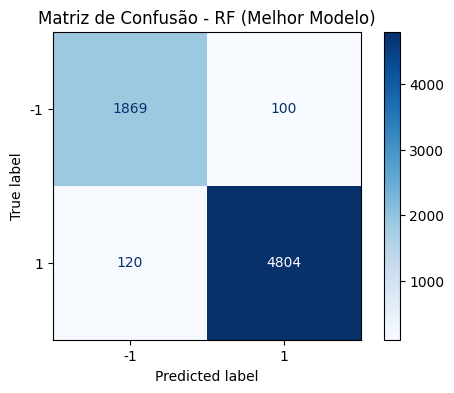

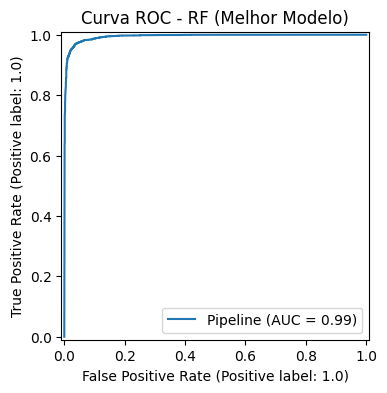

In [11]:
# Importações necessárias
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix


# 1) Plot da Matriz de Confusão
y_pred = best_rf_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[-1,1])

fig, ax = plt.subplots(figsize=(6, 4))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1]).plot(ax=ax, cmap='Blues')
plt.title("Matriz de Confusão - RF (Melhor Modelo)")
plt.show()

# 2) Plot da Curva ROC (para problemas binários)
# Se for binário, podemos usar directly from_estimator:
try:
    fig_roc, ax_roc = plt.subplots(figsize=(6, 4))
    RocCurveDisplay.from_estimator(best_rf_pipeline, X_test, y_test, ax=ax_roc)
    plt.title("Curva ROC - RF (Melhor Modelo)")
    plt.show()
except ValueError:
    print("Não foi possível gerar a Curva ROC (possivelmente é um problema multiclasse).")
